In [1]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import torch
from torch import nn

import sklearn as sk
from sklearn.ensemble import RandomForestRegressor

import confseq
from confseq import predmix, conjmix_bounded, betting

from Energy_ds.dataset import DataPrep, DataModule, EnergyDataset
from Energy_ds.config import SEASON, REGION, DatasetConfig

from neural.train import LightningTrainer
from neural.module import LightningModel, LightningWrapper
from neural.mlp import MlpBlock, RMLP, MLPLayer
from neural.config import TrainConfig

import risk
from risk import Risk
from algorithm import Hypothesis, ConfSeq




In [2]:
class HoffConf(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = predmix.predmix_hoeffding_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    
    @staticmethod
    def standardise(x):
        return (x - x.min()) / (x.max() - x.min())
    

class EmpbernConf(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val=min_val, max_val=max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)

        lower_cs, higher_cs = predmix.predmix_empbern_twosided_cs(x, self.conf_lvl, running_intersection=False)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    

class EmpbernConjmix(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = conjmix_bounded.conjmix_empbern_twosided_cs(x, 1/12, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

class EmpbernBetting(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = betting.betting_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

In [3]:
class H0(Hypothesis):
    def __init__(self, tolerance:float, lower_bound:ConfSeq, upper_bound:ConfSeq):
        super().__init__(tolerance, lower_bound, upper_bound)
    
    @property
    def source_upper(self):
        return self.source_upper_cs[-1] + self.tolerance
    
    @property
    def target_lower(self):
        return self.target_lower_cs


In [4]:
class DeployedModel:
    def __init__(
        self,
        model: RandomForestRegressor,
        hyp_tests: list[tuple[Hypothesis, Risk]]
    ):
        self.model = model
        self.hyp_tests = hyp_tests
        
        self.input_seq = None
        self.label_seq = None
        self.pred_seq = None

    def update(self, features:np.ndarray, labels: np.ndarray) -> bool:
        # features = features.reshape(-1, 1)
        preds = self.model.predict(features)
        # update input, label and prediction sequences
        self.input_seq = self._append_seq(features, self.input_seq)
        self.label_seq = self._append_seq(labels, self.label_seq)
        self.pred_seq = self._append_seq(preds, self.pred_seq)
        # update targed confidence bounds
        test_results = []
        for hyp, risk in self.hyp_tests:
            res = hyp.test(risk(self.input_seq, self.label_seq, self.pred_seq))
            test_results.append(res)
        return all(test_results)

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        # fit model
        self.model = self.model.fit(x, y)
        # calibrate source confidence bounds
        preds = self.model.predict(x)
        for hyp, risk in self.hyp_tests:
            risk_list = []
            for i in range(len(x)):
                risk_list.append(risk(x[:i+1], y[:i+1], preds[:i+1]))
            hyp.calc_source_upper_cs(np.asanyarray(risk_list))
        
    def to_dataframe(self):
        results = []
        for hyp, risk in self.hyp_tests:
            res = hyp.to_dataframe()
            # res['GT'] = self.label_seq
            res['risk'] = risk.__class__.__name__
            res['hyp'] = hyp.__class__.__name__
            results.append(res)
        return pd.concat(results, axis=0, ignore_index=True)
    
    def _append_seq(self, x:np.ndarray|float, seq:np.ndarray, dim:int=0) -> np.ndarray:
        """
        append the input x to the sequence.
        parameters:
            x (np.ndarray): The input array of shape (n_samples) or a float if x is a single sample.
            seq (np.ndarray): The sequence to append to.
        """
        if isinstance(x, float):
            x = np.asanyarray([x])
        
        if seq is None:
            return x

        new_seq = np.concatenate((seq, x), axis=dim)
        return new_seq

    def reset(self, source:bool=True, target:bool=True):
        if target:
            self.input_seq = None
            self.label_seq = None
            self.pred_seq = None
        for hyp, risk in self.hyp_tests:
            hyp.reset(source=source, target=target)

In [5]:
class Experiment:
    def __init__(
        self,
        model,
        # train_ds,
        # test_ds,
        test_batch_size=1,
        
    ):
        self.model: DeployedModel = model
        # self.train_ds: EnergyDataset = train_ds
        # self.test_ds: EnergyDataset = test_ds
        self.test_batch_size: int = test_batch_size

    def train(self, train_ds: EnergyDataset):
        self.model.fit(train_ds.features, train_ds.labels)

    def test(self, test_ds: EnergyDataset):
        ds_len = len(test_ds)
        for i in range(0, ds_len, self.test_batch_size):
            # prepare batch
            batch_end = min(i+self.test_batch_size, ds_len)
            x = test_ds.features[i:batch_end]
            y = test_ds.labels[i:batch_end]
            # print(f"batch {i} :: x.shape={x.shape}, y.shape={y.shape}")
            # predict
            result = self.model.update(x, y)

        return self.model.to_dataframe()

In [6]:
path = "Hourly_Energy_Consumption/AEP_hourly.csv"
all_paths = ['Hourly_Energy_Consumption/AEP_hourly.csv',
            'Hourly_Energy_Consumption/COMED_hourly.csv',
            'Hourly_Energy_Consumption/DAYTON_hourly.csv',
            'Hourly_Energy_Consumption/DEOK_hourly.csv',
            'Hourly_Energy_Consumption/DOM_hourly.csv',
            'Hourly_Energy_Consumption/DUQ_hourly.csv',
            'Hourly_Energy_Consumption/EKPC_hourly.csv',
            'Hourly_Energy_Consumption/FE_hourly.csv',
            'Hourly_Energy_Consumption/NI_hourly.csv',
            'Hourly_Energy_Consumption/PJME_hourly.csv',
            'Hourly_Energy_Consumption/PJMW_hourly.csv',
            # 'Hourly_Energy_Consumption/PJM_Load_hourly.csv',
            # 'Hourly_Energy_Consumption/est_hourly.paruqet',
            # 'Hourly_Energy_Consumption/pjm_hourly_est.csv'
            ]

In [7]:
prep = DataPrep(*all_paths)
data = prep.data

In [8]:
data.describe()

,Datetime,MW,Year,Day,Hour,Week_Number,Season,Region
count,1057271,1.057271e+06,1.057271e+06,1.057271e+06,1.057271e+06,1057271.0,1.057271e+06,1.057271e+06
mean,2011-11-30 12:43:11.199417856,1.063221e+04,2.011417e+03,1.572288e+01,1.150140e+01,26.393667,2.479493e+00,6.004170e+00
min,2002-01-01 01:00:00,0.000000e+00,2.002000e+03,1.000000e+00,0.000000e+00,1.0,1.000000e+00,1.000000e+00
25%,2008-05-14 07:00:00,2.377000e+03,2.008000e+03,8.000000e+00,6.000000e+00,14.0,1.000000e+00,3.000000e+00
50%,2012-06-17 08:00:00,7.822000e+03,2.012000e+03,1.600000e+01,1.200000e+01,26.0,2.000000e+00,6.000000e+00
75%,2015-07-28 17:00:00,1.386400e+04,2.015000e+03,2.300000e+01,1.800000e+01,39.0,3.000000e+00,9.000000e+00
max,2018-08-03 00:00:00,6.200900e+04,2.018000e+03,3.100000e+01,2.300000e+01,53.0,4.000000e+00,1.100000e+01
std,NaN,1.011504e+04,4.293924e+00,8.802928e+00,6.921839e+00,14.994158,1.122064e+00,3.209681e+00


In [9]:
label_min_val = 0
label_max_val = 800

In [10]:
train_config = DatasetConfig(
    past_window=24,
    years=(2006, 2007),
    region=[REGION.AEP],
)
test_config = DatasetConfig(
    past_window=24,
    years=(2007, 2008),
    region=[REGION.AEP],
)

In [11]:
train_ds = EnergyDataset(path, train_config)
test_ds = EnergyDataset(path, test_config)

columns = train_ds.features_df.columns

In [12]:
rf = RandomForestRegressor()


In [52]:
mse_risk = risk.MSE()
mae_risk = risk.MAE()
hyp_test_1 = H0(tolerance=0.1,
                lower_bound=EmpbernConf(0.05),
                upper_bound=EmpbernConf(0.05)
                )



In [53]:
model = DeployedModel(rf, [(hyp_test_1, mae_risk)])

In [54]:
experiment = Experiment(model, test_batch_size=10)

In [55]:
experiment.model.reset(source=True, target=True)

In [56]:
# model = experiment.model.model.fit(train_ds.features, train_ds.labels)

In [57]:
# data = {'err':np.abs(experiment.model.predict(test_ds.features) - test_ds.labels)}
# pd.DataFrame(data).describe()

In [58]:
experiment.train(train_ds)

In [59]:

results = experiment.test(train_ds)

/home/guycoh/new/ReliabilityInML_Project/algorithm.py:59: RuntimeWarning: invalid value encountered in divide
  normalized = (self._risk_seq - min_val) / (max_val - min_val)


In [60]:
results

,risk_seq,source_upper_bound,target_lower_cs,time,tol,rejected,source_bound,source_confidence,target_bound,target_confidence,risk,hyp
0,85.482000,59.795293,51.516400,0,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0
1,73.607500,59.795293,51.516400,1,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0
2,59.803333,59.795293,51.516400,2,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0
3,55.706500,59.795293,51.516400,3,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0
4,58.574600,59.795293,51.516400,4,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0
...,...,...,...,...,...,...,...,...,...,...,...,...
871,60.553162,59.795293,58.930526,871,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0
872,60.553288,59.795293,58.932370,872,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0
873,60.575729,59.795293,58.934234,873,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0
874,60.580909,59.795293,58.936100,874,0.1,False,EmpbernConf,0.05,EmpbernConf,0.005,MAE,H0


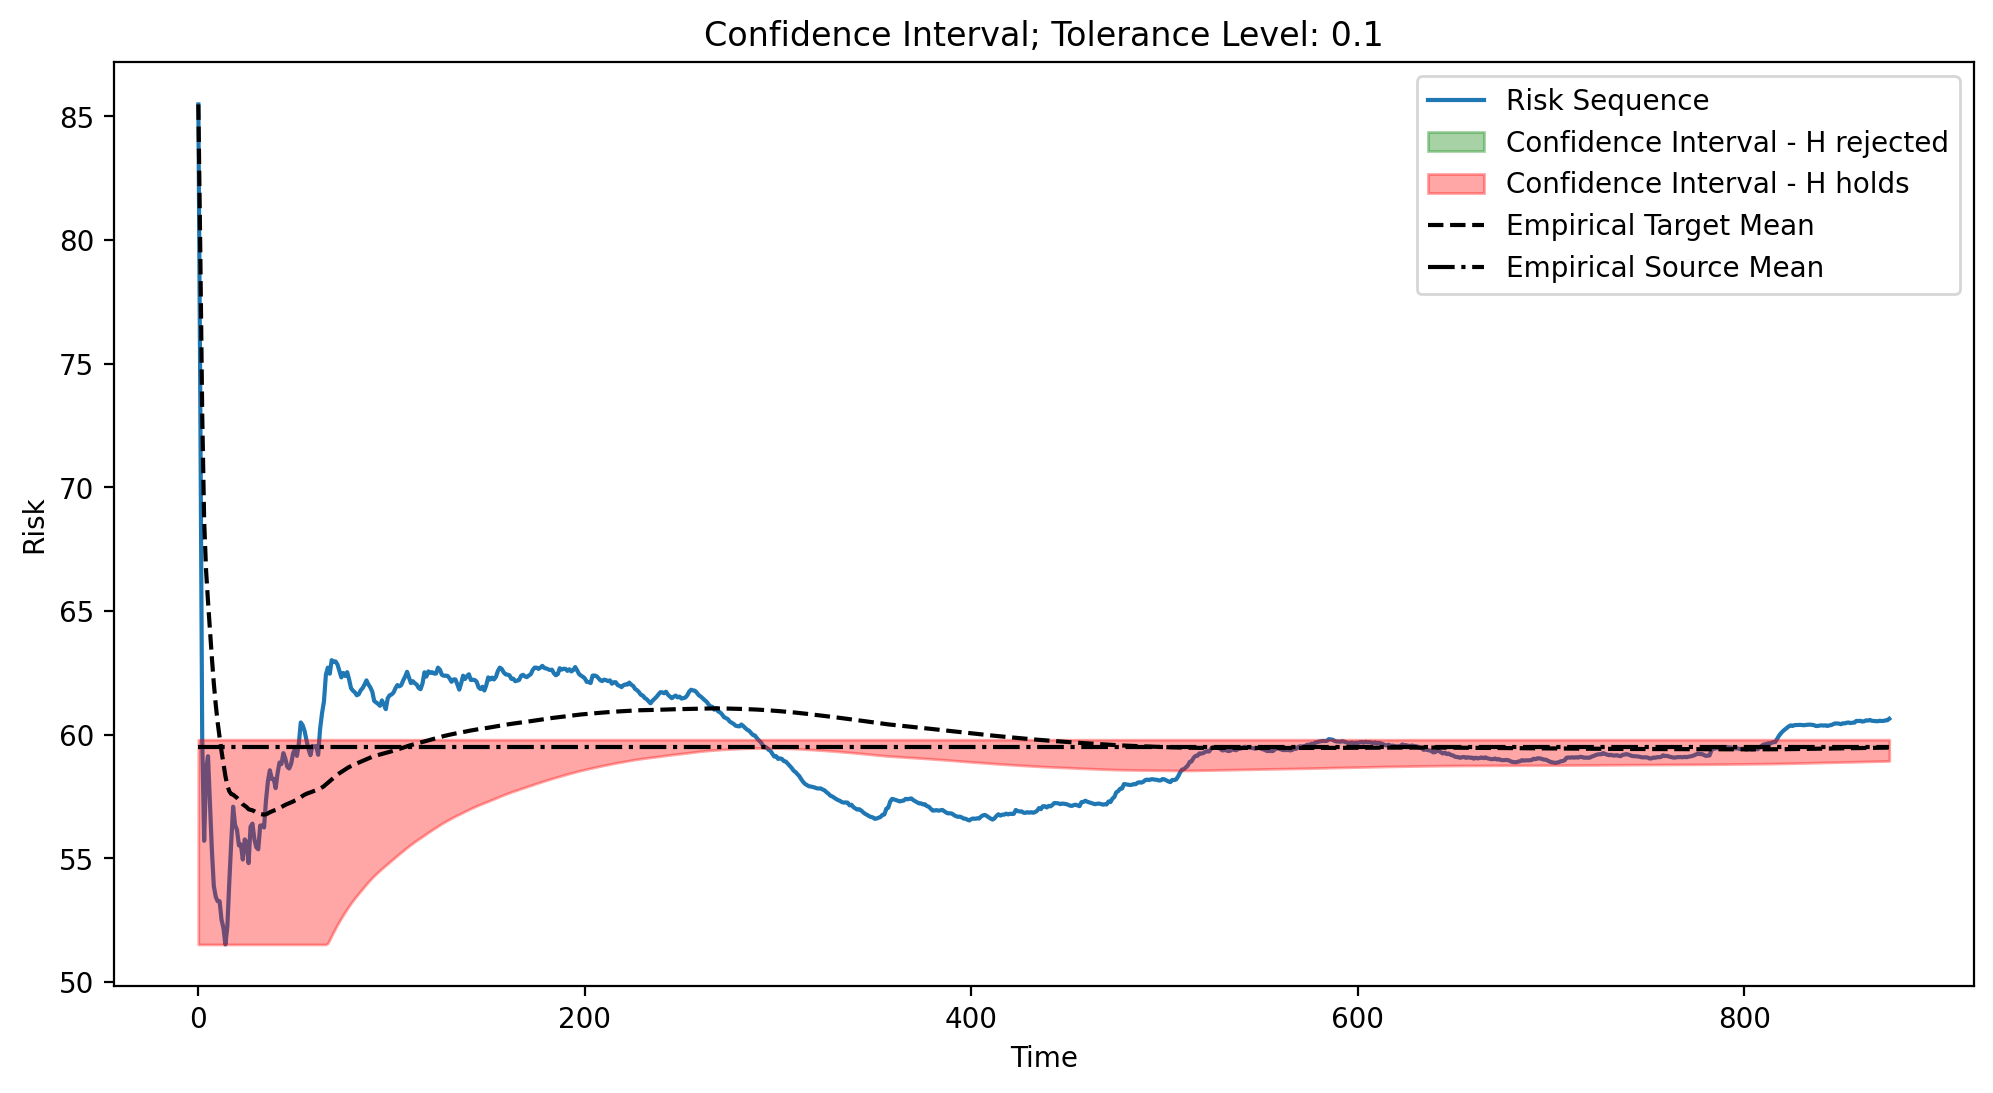

In [62]:
experiment.model.hyp_tests[0][0].plot()

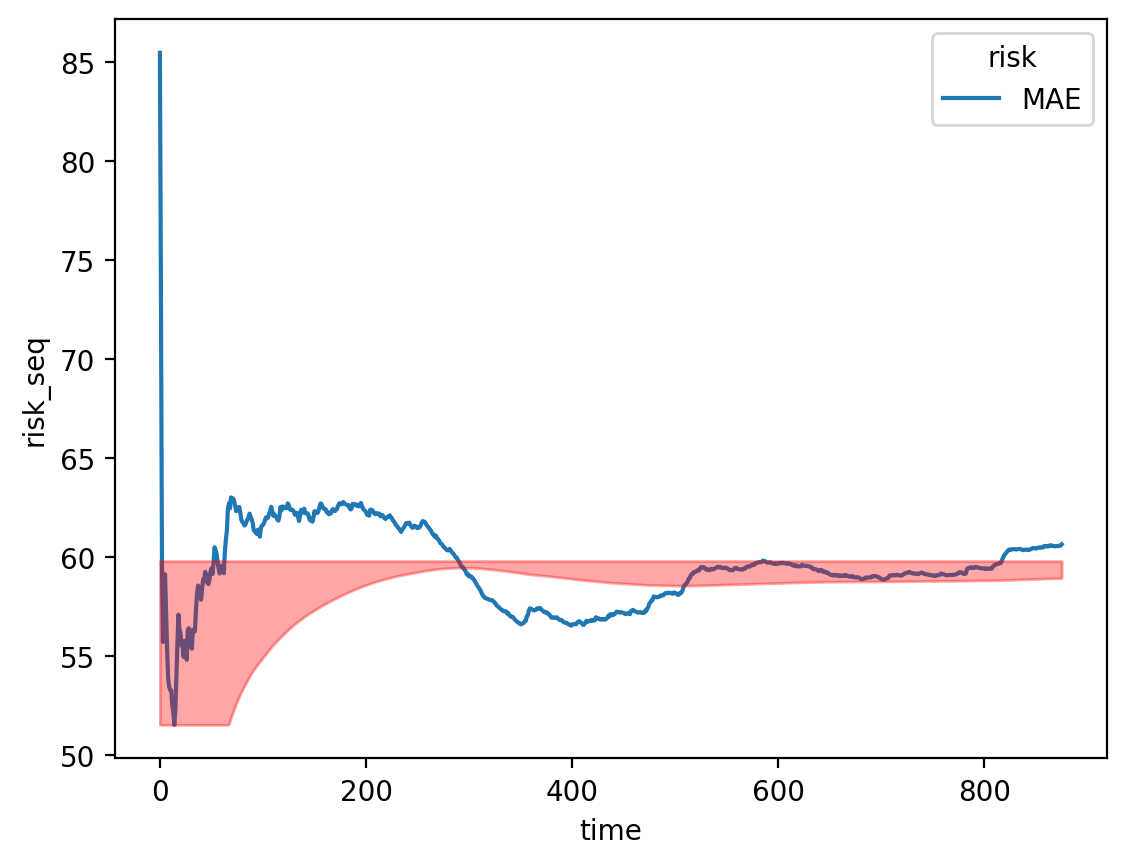

In [66]:
fig, axes = plt.subplots(1, dpi=200)
g = sns.lineplot(data=results, x='time', y='risk_seq', ax=axes, hue='risk')
diff =  (results['target_lower_cs'] - results['source_upper_bound'])
g.fill_between(results['time'], results['target_lower_cs'], results['source_upper_bound'], where=diff > 0, alpha=0.35, color='green', label='Confidence Interval - H rejected', zorder=10)
g.fill_between(results['time'], results['target_lower_cs'], results['source_upper_bound'], where=diff < 0, alpha=0.35, color='red', label='Confidence Interval - H holds', zorder=10)


# OLD

In [2]:
settings = TrainConfig(
        # loss_fn = 'bce', # str
        # optimizer = 'adam', # str
        device = f"gpu", # str
        log = False, # bool
        logs_dir = "logs/", # str
        num_epochs = 30, # int
        checkpoints = 'test.pt', # str
        early_stopping = None, # int
        log_every = 1, # int
        timeout = "00:12:00:00", # int
        # learning_rate = 0.001, # float
        # weight_decay = 1e-06, # float
        batch_size = 2048, # int
        shuffle = False, # bool
        num_workers = 9, # int
        # train_test_split = 0.5, # float
    )

In [ ]:
path = "Hourly_Energy_Consumption/AEP_hourly.csv"
past_hours = 2

prper = DataPrep(path)
data = prper.data

# train_years = range(2004, 2016)
# val_years = range(2016, 2018)

def year_cond(start:int, end:int):
    return lambda data: data['Year'].between(start, end)

def season_cond(season:SEASON):
    return lambda data: data['Season'] == season.value

def month_cond(month:int):
    return lambda data: data['Month'] == month

def cond_and(conds:list):
    def cond(data):
        mask = pd.Series(len(data)*[True])
        for c in conds:
            mask = mask & c(data)
        return mask
    # return lambda data: ([cond(data) for cond in conds])
    return cond

train_conds = [year_cond(2006, 2008), season_cond(SEASON.WINTER)]
val_conds = [year_cond(2009, 2012), season_cond(SEASON.SUMMER)]

train_ds = EnergyDataset(path, past_hours=past_hours, condition=cond_and(train_conds))
val_ds = EnergyDataset(path, past_hours=past_hours, condition=cond_and(val_conds))


datamodule = DataModule(train_ds,
                        val_ds,
                        batch_size=settings.batch_size,
                        num_workers=settings.num_workers,
                        shuffle=settings.shuffle,
                        seed=42,
                        )


In [ ]:
train_ds.labels_df

In [ ]:
train_ds.data_df

In [ ]:
train_ds[0]

In [9]:
# datamodule.prepare_data()
dl = datamodule.train_dataloader()

In [10]:
batch, label = next(iter(dl))
n_features = batch.shape[-1]

In [ ]:
batch.shape, label.shape

In [31]:
from torch import Tensor


class ResidMLP(LightningModel):
    def __init__(self, input_size, hidden_size, output_size=1, loss:nn.Module=nn.L1Loss()):
        super().__init__(loss)
        # self.f = nn.TransformerEncoderLayer(input_size,
        #                                     nhead=4,
        #                                     dim_feedforward=hidden_size[-1],
        #                                     dropout=0.1,
        #                                     activation='relu',
        #                                     batch_first=True)
        
        # self.rmlp = RMLP(
        #     in_dim=input_size,
        #     block_in_dim=hidden_size[0], 
        #     block_dims=hidden_size,
        #     block_nonlins=[nn.ReLU()]*len(hidden_size),
        #     n_blocks=2,
        #     out_dim=output_size,
        #     out_nonlin=nn.Identity(),
        #     batch_norm=False,
        #     )
        # self.mlp = MlpBlock(
        #     in_dim=input_size,
        #     dims=hidden_size,
        #     nonlins=[nn.Tanh()]*len(hidden_size),
        #     batch_norm=False,
        #     )
        self.out_layer = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        # x = x.flatten(1).to(torch.float32)
        # x = self.rmlp(x)
        # x = self.mlp(x)
        # x = self.f(x)
        return self.out_layer(x)#.squeeze(-1)
    
    def accuracy(self, preds: Tensor, labels: Tensor) -> Tensor:
        return (preds - labels).abs().mean()
    


In [ ]:
in_size = n_features#*past_hours
rmlp = ResidMLP(input_size=in_size, hidden_size=[24, 16], output_size=1)

model = LightningWrapper(rmlp)
print(model)

In [ ]:
trainer = LightningTrainer(settings, "global_wheat_1")
train_dl, val_dl = datamodule.train_dataloader(), datamodule.val_dataloader()
trainer.fit(model, dl_train=train_dl, dl_test=val_dl)


In [10]:
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor

In [11]:
rf = RandomForestRegressor()


In [12]:
rf = rf.fit(train_ds.features, train_ds.labels)

In [13]:
def mae(preds, labels):
    return np.abs(preds - labels).mean()

In [17]:
train_scores = mae(rf.predict(train_ds.features), train_ds.labels.numpy())
val_scores = mae(rf.predict(val_ds.features), val_ds.labels.numpy())

In [69]:

def validate(model:RandomForestRegressor, val_dl):
    scores = []
    for batch, label in val_dl:
        score = np.abs(model.predict(batch.numpy()) - label.numpy()).flatten()
        scores.append(score)
    return np.concatenate(scores)

train_scores = validate(rf, train_dl)
val_scores = validate(rf, val_dl)
# scores = []
# for batch, label in val_dl:
#     score = np.abs(rf.predict(batch.numpy()) - label.numpy()).mean()
#     scores.append(score)
# print(np.mean(scores))

In [ ]:
print(f"train_score = {train_scores.mean()}")
print(f"val_score = {val_scores.mean()}")

In [ ]:
model(batch)